In [1]:
import pandas as pd
import numpy as np

In [30]:
from xgboost import XGBRegressor

In [32]:
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [39]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Create rolling-windows and come up with features with min, max, mean and std 

In [5]:
train_df_new = pd.read_csv('train_df.csv',index_col='Unnamed: 0')

E:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train_df_new.head().append(train_df_new.tail())

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,2,5572,2.0,10730.00,1532.8572,9.0,1.285714,7.0,2013,0,1.0,1192.0,0.0,18979.5,10730.00,8249.50
1,0,2,5643,2.0,4775.21,2387.6050,0.0,0.000000,2.0,2013,0,0.0,inf,0.0,35260.0,4775.21,30484.79
2,0,2,5583,5.0,1188.30,594.1500,2.0,1.000000,2.0,2013,0,1.0,594.0,0.0,5592.0,1188.30,4403.70
3,0,2,7893,6.0,5970.00,1990.0000,3.0,1.000000,3.0,2013,0,2.0,1990.0,0.0,27950.0,5970.00,21980.00
4,0,2,7894,6.0,1490.00,1490.0000,1.0,1.000000,1.0,2013,0,2.0,1490.0,0.0,25880.0,1490.00,24390.00
6728113,33,36,9103,0.0,0.00,0.0000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,500.0,0.00,500.00
6728114,33,36,9107,0.0,0.00,0.0000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,300.0,0.00,300.00
6728115,33,36,5704,0.0,0.00,0.0000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,1750.0,0.00,1750.00
6728116,33,36,12733,0.0,0.00,0.0000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,2980.0,0.00,2980.00
6728117,33,36,15925,0.0,0.00,0.0000,0.0,0.000000,0.0,2015,9,NaN,0.0,0.0,11899.0,0.00,11899.00


Create rolling-windows and come up with features with min, max, mean and std 

In [7]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()
 
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']
 
for i in range(len(function_list)):
    train_df_new[('item_cnt_%s' % function_name[i])] = train_df_new.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

#print(train_df_new)

# Fill the empty std features with 0
train_df_new['item_cnt_std'].fillna(0, inplace=True)

In [8]:
lag_list = [1, 2, 3]
 
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_df_new[ft_name] = train_df_new.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_df_new[ft_name].fillna(0, inplace=True)

Create shifted features(lagging) for 3 previous consecutive months

In [9]:
lag_list = [1, 2, 3]
 
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_df_new[ft_name] = train_df_new.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_df_new[ft_name].fillna(0, inplace=True)

Create a feature for item sales trend, which could be calculated by substracting the lagging sales from current sales and take the average to represent the change.

In [11]:
train_df_new['item_trend'] = train_df_new['item_cnt']
 
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_df_new['item_trend'] -= train_df_new[ft_name]
 
train_df_new['item_trend'] /= len(lag_list) + 1

We get rid of the first three months' data because the lagging features we just created would be null. 

In [12]:
train_set = train_df_new.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_df_new.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_df_new.query('date_block_num == 33').copy()
 
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)
 
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [13]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)
 
 
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [14]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [15]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']
 
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [17]:
test = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})


In [18]:
#Fill in the features for test data(it only contains shop_id & item_id before, but we would predict on more features). The feature value filled in are the last record from train data corresponding to the item_id and shop_id 

latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')

X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])  
X_test.head().append(X_test.tail())
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [19]:
#Fill null values with median
sets = [X_train, X_validation, X_test]
 
            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [20]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [21]:
print(X_train.head())

   shop_id  item_id  item_price  mean_item_price  item_cnt  mean_item_cnt  \
0      2.0   5572.0      2980.0           1490.0       2.0            1.0   
1      2.0   5643.0         0.0              0.0       0.0            0.0   
2      2.0   5583.0         0.0              0.0       0.0            0.0   
3      2.0   7893.0      9350.0           1870.0       5.0            1.0   
4      2.0   7894.0         0.0              0.0       0.0            0.0   

   transactions    year  month  item_price_unit  ...  item_cnt_std  \
0           2.0  2013.0    3.0           1490.0  ...      0.577350   
1           0.0  2013.0    3.0              0.0  ...      0.000000   
2           0.0  2013.0    3.0              0.0  ...      0.000000   
3           5.0  2013.0    3.0           1870.0  ...      2.081666   
4           0.0  2013.0    3.0              0.0  ...      0.000000   

   item_cnt_shifted1  item_cnt_shifted2  item_cnt_shifted3  item_trend  \
0                1.0                1.0   

In [22]:
print(X_validation.head())

   shop_id  item_id  item_price  mean_item_price  item_cnt  mean_item_cnt  \
0      2.0   5572.0      1590.0          1590.00       1.0            1.0   
1      2.0   5643.0         0.0             0.00       0.0            0.0   
2      2.0   5583.0         0.0             0.00       0.0            0.0   
3      2.0   7893.0         0.0             0.00       0.0            0.0   
4      2.0   7894.0      4579.5          2289.75       2.0            1.0   

   transactions    year  month  item_price_unit  ...  item_cnt_std  \
0           1.0  2015.0    4.0           1590.0  ...      0.000000   
1           0.0  2015.0    4.0              0.0  ...      0.000000   
2           0.0  2015.0    4.0              0.0  ...      0.000000   
3           0.0  2015.0    4.0              0.0  ...      0.000000   
4           2.0  2015.0    4.0           2289.0  ...      2.081666   

   item_cnt_shifted1  item_cnt_shifted2  item_cnt_shifted3  item_trend  \
0                1.0                1.0   

# Model

## 1. XGBoost

In [31]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]
 
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[15:43:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:43:05] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.942838	validation_1-rmse:0.92285
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.684562	validation_1-rmse:0.790805
Stopping. Best iteration:
[18]	validation_0-rmse:0.687705	validation_1-rmse:0.788256



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

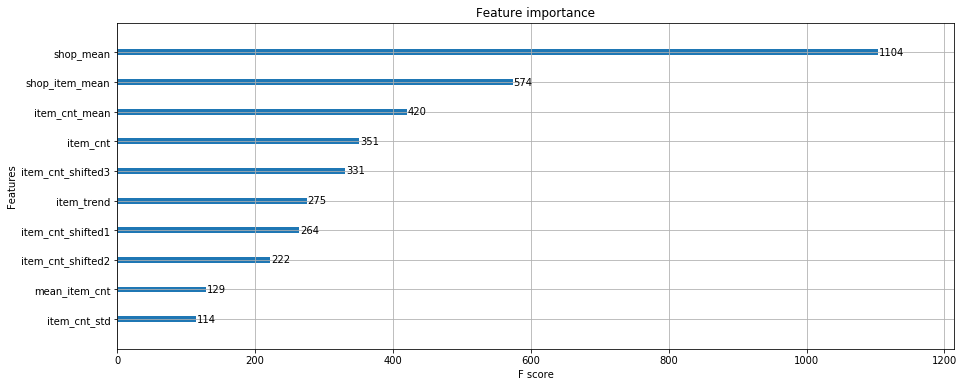

Train rmse: 0.692250599852641
Validation rmse: 0.7897789171758853


In [41]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

## 2. RandomForest

In [44]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]
 
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [46]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)
 
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6986130498585467
Validation rmse: 0.7761624203123252


## 3. LinearRegression

In [47]:
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]
 
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)
 
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [48]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347110565392222
Validation rmse: 0.7755309685532078


## 4. KNN

In [49]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']
 
# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]
 
knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]
 
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)
 
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [50]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.48654615453605954
Validation rmse: 0.8003598014372081


# Dataset that will be the train set of the ensemble model.

In [51]:
first_level = pd.DataFrame(xgb_val_pred, columns=['xgbm'])
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,xgbm,random_forest,linear_regression,knn,label
0,0.688442,0.621809,0.598764,1.000000,0
1,0.638456,0.557902,0.044736,0.777778,0
2,0.103210,0.207674,0.044736,0.000000,0
3,0.814267,0.947778,0.044736,0.111111,4
4,1.588363,1.566086,1.455702,0.666667,1
5,0.638456,0.457695,0.044736,0.111111,1
6,0.439195,0.207674,0.044736,0.111111,0
7,0.103210,0.059621,0.044736,0.000000,1
8,0.368585,0.207674,0.044736,0.111111,0
9,1.732229,1.125031,1.151157,2.888889,2


In [52]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgbm'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()
# Create a meta_model and vote
meta_model = LinearRegression(n_jobs=-1)

In [53]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)

In [54]:
meta_model.fit(first_level, Y_validation)
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [55]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7649992807983159


In [59]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df['item_cnt_month']= prediction_df['item_cnt_month'].round(2)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.82
1,1,0.08
2,2,1.27
3,3,0.06
4,4,0.08
5,5,0.94
6,6,1.24
7,7,0.21
8,8,1.98
9,9,0.06
